This notebook analyzes the campaigns speeches of Clinton and Trump.
It uses topic modeling, along with signature computation.
This is only focused on the presidential campaign , without the primaries

In [1]:
%matplotlib inline

In [69]:
import json

import numpy as np
import os
import re
import html

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn import cluster
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import nltk.help
import nltk
from textblob import TextBlob

import datetime

from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.sparse import find

from code_these_clement.utils.signature_func import compute_sky_signature

In [3]:
# We load the annotated speeches (speech with speaker name, date and event)
annotated_speeches_path = r"C:\Users\cgautrai\workspace\repo_these\code_these_clement\scraping\pres_speeches\annotated_speeches.json"
speeches = []
with open(annotated_speeches_path) as annotated_speeches_file:
    speeches = json.load(annotated_speeches_file)
    speeches = sorted(speeches, key=lambda o:datetime.datetime.strptime(o["date"], "%B %d, %Y").timestamp())
    # We only keep the speeches that are after the nomination of Clinton
    speeches = [s for s in speeches if datetime.datetime.strptime(s["date"], "%B %d, %Y") > datetime.datetime(2016, 7, 20)]

In [4]:
# This is the function that processes the raw data and return a list of currated speeches
def get_processed_speeches(politician):
    politician_speeches = []
    
    cachedStopWords = stopwords.words("english")
    # We also remove way too frequent words
    cachedStopWords.extend(["clinton", "trump", "donald", "hillary", "america", "american", "country", "people", "lot", "mr"])
    # We only keep some POS tags
    kept_pos_tags = ["FW", "JJ", "JJR", "JJS", "NN", "NNS"]# "NNP", "NNPS"]#, "RBR", "RBS"]# "VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]
    lmtzr = WordNetLemmatizer()
    for speech in speeches:
        politician_talks = []
        for paragraph in speech["annotated_text"]:
            if politician.upper() in paragraph["speaker"].upper():
                politician_talks.append(html.unescape(paragraph["text"]))
        if politician_talks:
            overall_speech = " ".join(politician_talks)
            #blob = TextBlob(overall_speech)
            # We'll do a smarter thing by filtering by pos tags
            #speech_nouns = " ".join(blob.noun_phrases)
            tokenized_speech_words = word_tokenize(overall_speech)
            pos_tags = nltk.pos_tag(tokenized_speech_words)
            lemmatized_speech_words = [lmtzr.lemmatize(w.lower()) for i,w in enumerate(tokenized_speech_words) if pos_tags[i][1] in kept_pos_tags]
            speech_words = [w for w in lemmatized_speech_words if w not in cachedStopWords]
            politician_speeches.append(" ".join(speech_words))
    return politician_speeches

In [5]:
def get_speeches_dates(politician):
    all_dates = []
    for speech in speeches:
        for paragraph in speech["annotated_text"]:
            if politician.upper() in paragraph["speaker"].upper():
                all_dates.append(datetime.datetime.strptime(speech["date"], "%B %d, %Y"))
                break
    return all_dates

In [6]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] + ":" + '{:.4f}'.format(topic[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [7]:
clinton_speeches = get_processed_speeches("Clinton")
trump_speeches = get_processed_speeches("Trump")
all_speeches = clinton_speeches[:]
all_speeches.extend(trump_speeches)

# We now transform tweets using vectorizers
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_vectors = tfidf_vectorizer.fit_transform(all_speeches)

count_vectorizer = CountVectorizer(stop_words='english', max_df=0.8)
count_vectors = count_vectorizer.fit_transform(all_speeches)

In [8]:
print(len(clinton_speeches))
print(len(trump_speeches))
print(len(all_speeches))
print(len(count_vectorizer.vocabulary_))

41
63
104
4847


In [27]:
# Fit the NMF model
n_topics = 12
n_top_words = 15
nmf = NMF(n_components=n_topics, alpha=.2, l1_ratio=.2, random_state=2).fit(count_vectors)

print("\nTopics in NMF model:")
tfidf_feature_names = count_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)


Topics in NMF model:
Topic #0:
tax:6.2759 dollar:2.3150 trade:2.2519 worker:1.9684 energy:1.7749 regulation:1.6562 economic:1.5185 policy:1.4971 economy:1.4643 income:1.3999 reform:1.3926 growth:1.2566 percent:1.1358 company:1.0306 small:0.9442
Topic #1:
election:3.3876 president:3.0611 kind:2.9081 sure:2.2589 everybody:2.0853 right:1.7091 issue:1.5358 important:1.4855 college:1.4324 work:1.4152 economy:1.2595 young:1.2564 debt:1.2356 debate:1.2312 hard:1.1862
Topic #2:
big:2.3184 money:2.1154 folk:2.1134 percent:1.9794 right:1.7371 deal:1.7361 place:1.7188 bad:1.5697 wall:1.5032 tough:1.4107 guy:1.3517 baby:1.2431 everybody:1.0921 reason:1.0638 look:1.0603
Topic #3:
immigration:3.7984 illegal:3.1282 law:2.7349 immigrant:2.3170 border:2.0538 criminal:1.9230 administration:1.4420 enforcement:1.3690 visa:1.3599 worker:1.2564 amnesty:1.1369 federal:0.9701 issue:0.9561 crime:0.9538 alien:0.9426
Topic #4:
african:2.6458 future:2.5281 city:2.3742 american:2.1447 policy:1.7836 citizen:1.4850

In [28]:
# Hand crafted labels for each topic: CHANGE THAT IF YOU CHANGE THE TOPIC MODELING CODE
# New topics : 12 with count vectors
topics_labels = ["Economic policy", "Next President challenges", "Money people", "Illegal immigration", "Future of African Americans",
                 "Middle East policy", "Criticism of Democrats", "Climate Change issues", "Social policy",
                 "Criticism of former gvt", "Education policy", "Criticism of economic policy"]

In [29]:
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=200,learning_method='batch')

lda.fit(count_vectors)

print("\nTopics in LDA model:")
tf_feature_names = count_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)
print(lda.perplexity(tfidf_vectors))


Topics in LDA model:
Topic #0:
tax:262.1506 deal:201.7690 trade:193.5282 city:175.1229 policy:166.1143 nation:160.7115 government:159.8182 african:153.5790 future:150.5503 american:135.6452 dollar:133.1244 change:118.6816 worker:116.8275 money:115.3460 special:115.3441
Topic #1:
nuclear:15.6707 tonight:9.0833 president:8.9908 weapon:8.8591 election:8.2748 debate:7.6734 dinner:7.0833 policy:6.3079 ally:6.2224 moment:5.4745 crisis:5.3956 decision:5.2674 war:4.9937 party:4.8471 russian:4.7523
Topic #2:
folk:33.1347 deal:26.3765 big:24.9181 money:24.4579 wall:23.3885 guy:20.9962 percent:20.9751 right:20.1325 tough:19.9691 place:19.2183 drug:16.5520 baby:15.9401 election:15.1544 reason:14.0477 everybody:13.3608
Topic #3:
energy:31.0833 tax:12.0833 production:11.0833 economic:8.0833 coal:8.0833 gas:7.0833 dollar:7.0833 percent:7.0833 shale:7.0833 natural:6.0833 restriction:6.0833 public:5.0833 safety:5.0833 safe:5.0833 project:5.0833
Topic #4:
illegal:132.2633 immigration:120.5182 border:11

In [28]:
print(all_speeches[0][:300])

ready thing thing ready something president way tough economic time deck favor top everyday champion champion family strong strong road vote time journey


In [30]:
# We now transform our documents
speeches_topics = nmf.transform(count_vectors)
politician_speaker_list = [0 for i in range(len(clinton_speeches))]
politician_speaker_list.extend([1 for i in range(len(trump_speeches))])

In [133]:
# We do some plotting of different topics depending on the speaker
# for topic_id in range(n_topics):
#     plt.scatter(range(len(speeches_topics[:,topic_id])), speeches_topics[:,topic_id], c=politician_speaker_list, cmap="Paired")
#     plt.show()

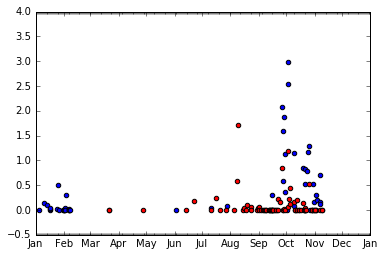

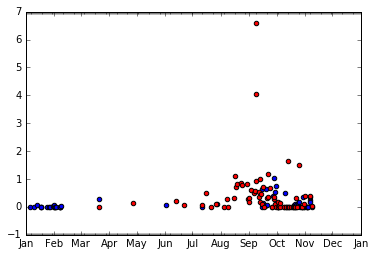

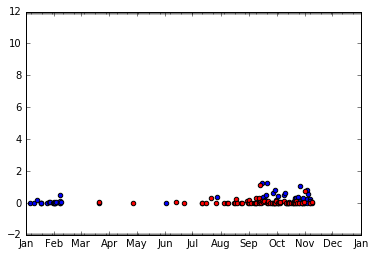

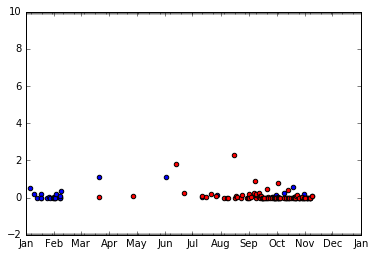

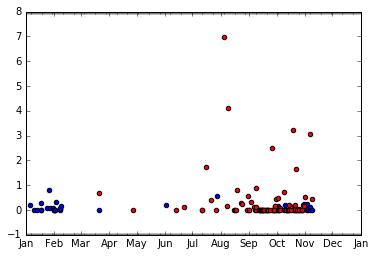

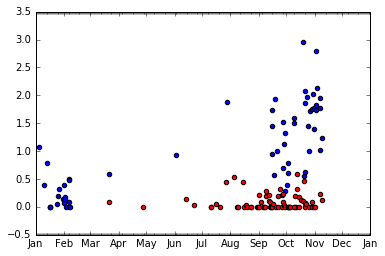

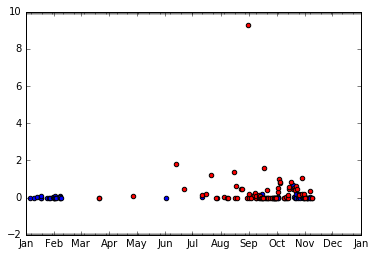

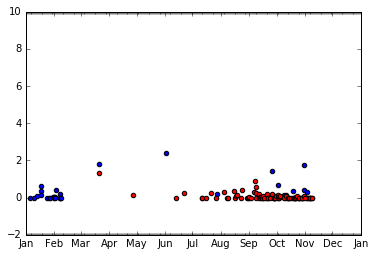

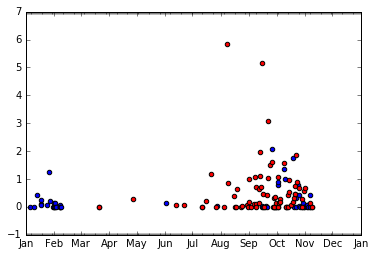

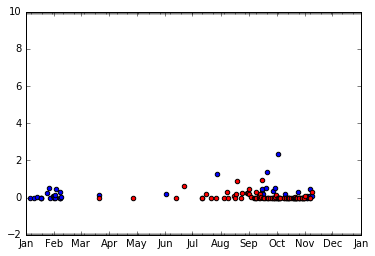

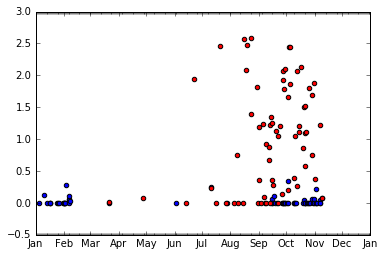

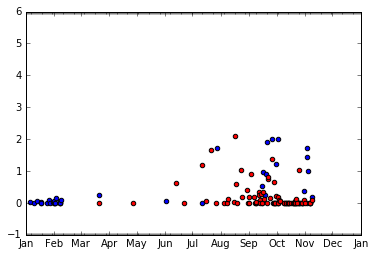

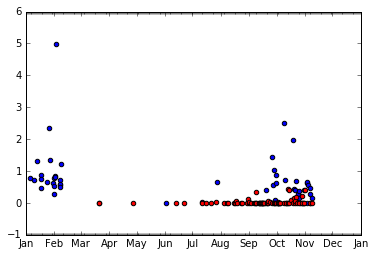

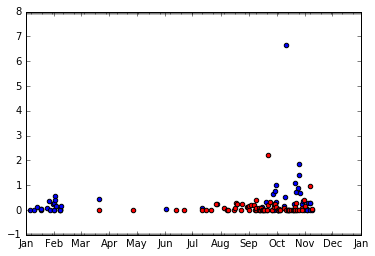

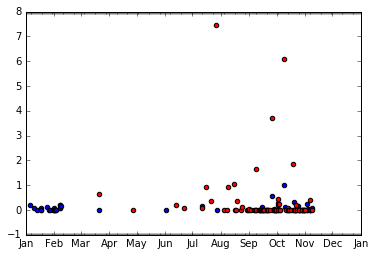

In [153]:
days = mdates.DayLocator()   # every day
months = mdates.MonthLocator()  # every month

trump_dates = get_speeches_dates("Trump")
clinton_dates = get_speeches_dates("Clinton")

for topic_id in range(n_topics):
    fig, ax = plt.subplots()
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.xaxis.set_minor_locator(days)
    
    datemin = datetime.date(min(clinton_dates).year+1, 1, 1)
    datemax = datetime.date(max(clinton_dates).year + 1, 1, 1)
    ax.set_xlim(datemin, datemax)
    
    ax.scatter(clinton_dates,speeches_topics[:len(clinton_speeches), topic_id])
    ax.scatter(trump_dates,speeches_topics[len(clinton_speeches):, topic_id],c='r')
    ax.plot()

In [31]:
# For each speech we keep the top 5 topics
speech_topic_nb = 3
speeches_main_topics = []
for speech_topics in speeches_topics:
    #top_topics = [i for i,val in enumerate(speech_topics) if val>0.01]
    top_topics = sorted(range(len(speech_topics)), key=lambda i: speech_topics[i], reverse=True)[:speech_topic_nb]
    speeches_main_topics.append(top_topics)

In [84]:
# We try a smarter selection process based on clustering to get the main topics of each speech
speeches_main_topics = []
for speech_topics in speeches_topics:
    clust = cluster.SpectralClustering(n_clusters=2)
    clust.fit_predict(speech_topics.reshape(-1,1))
    clust_1 = [i for i in range(len(speech_topics)) if clust.labels_[i] == 1]
    clust_0 = [i for i in range(len(speech_topics)) if clust.labels_[i] == 0]
    # We add the cluster with the highest values
    if np.mean([speech_topics[i] for i in clust_0]) > np.mean([speech_topics[i] for i in clust_1]):
        speeches_main_topics.append(clust_0)
    else:
        speeches_main_topics.append(clust_1)

In [85]:
trump_dates = get_speeches_dates("Trump")
clinton_dates = get_speeches_dates("Clinton")

days = mdates.DayLocator()   # every day
months = mdates.MonthLocator()  # every month

# Init the plot and its properties
fig, ax = plt.subplots()

ax.yaxis.set_major_locator(months)
ax.yaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.yaxis.set_minor_locator(days)

datemin = datetime.date(min(clinton_dates).year, 8, 1)
datemax = datetime.date(max(clinton_dates).year, 12, 1)
ax.set_ylim(datemin, datemax)
ax.set_xlim(-0.2, len(topics_labels)*0.4)
ax.set_xticklabels(topics_labels, rotation=90)
ax.set_xticks([0+i*0.4 for i in list(range(len(topics_labels)))])
    
# We do the plot for Clinton first
for i, topic in enumerate(speeches_main_topics[:len(clinton_dates)]):    
    c=ax.scatter([t*0.4-0.1 for t in topic],[clinton_dates[i]]*len(topic), c='b', s=speeches_topics[i, topic]*20)
    
# We do it for trump next
for i, topic in enumerate(speeches_main_topics[len(clinton_dates):]):    
    t=ax.scatter([t*0.4+0.1 for t in topic], [trump_dates[i]]*len(topic), c='r', s=speeches_topics[len(clinton_dates)+i, topic]*20)
    
# We also add dashed vertical lines to separate topics
for i in [0+i*0.4 for i in list(range(len(topics_labels)))]:
    plt.axvline(x=i, ls="dashed", color="k")
    plt.axvline(x=i+0.2, color="k", linewidth=3)

fig.set_figheight(10)
fig.set_figwidth(20)
fig.tight_layout()
lgnd = ax.legend([c,t],["Clinton speech", "Trump speech"], loc=3, scatterpoints=1)
lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]
ax.plot()
fig.savefig("pres_campaign_topics.pdf")

In [86]:
# We now apply the signature on it, so we modify our data to fit in there
# We begin with Clinton signature
jar_path = "./code_these_clement/resources/signatures.jar"
clinton_dataset = []
for i, topic in enumerate(speeches_main_topics[:len(clinton_dates)]):
    if topic:
        clinton_dataset.append({'timestamp':int(clinton_dates[i].timestamp()), 'products':["%05d" % t for t in topic]})
sign_clinton = compute_sky_signature(clinton_dataset, jar_path, 0.1, runner="fr.liglab.datalyse.retail.runners.RunSkySignatureComputation")

trump_dataset = []
for i, topic in enumerate(speeches_main_topics[len(clinton_dates):]):
    if topic:
        trump_dataset.append({'timestamp':int(trump_dates[i].timestamp()), 'products':["%05d" % t for t in topic]})
sign_trump = compute_sky_signature(trump_dataset, jar_path, 0.1, runner="fr.liglab.datalyse.retail.runners.RunSkySignatureComputation")

In [68]:
trump_dates = get_speeches_dates("Trump")
clinton_dates = get_speeches_dates("Clinton")

days = mdates.DayLocator()   # every day
months = mdates.MonthLocator()  # every month

# Init the plot and its properties
fig, ax = plt.subplots()

ax.yaxis.set_major_locator(months)
ax.yaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.yaxis.set_minor_locator(days)

datemin = datetime.date(min(clinton_dates).year, 7, 1)
datemax = datetime.date(max(clinton_dates).year, 11, 15)
ax.set_ylim(datemin, datemax)
ax.set_xlim(-0.2, len(topics_labels)*0.4+0.1)
ax.set_xticklabels(topics_labels + ["Illegal immigration + main topics", "Education policy + main topics"], rotation=90)
ax.set_xticks([0+i*0.4 for i in list(range(len(topics_labels)))] + [0.4*n_topics-0.1, 0.4*n_topics])
    
# We do the plot for Clinton first
for i, topic in enumerate(speeches_main_topics[:len(clinton_dates)]):    
    c=ax.scatter([t*0.4-0.1 for t in topic],[clinton_dates[i]]*len(topic), c='b', s=speeches_topics[i, topic]*20)
    
# We do it for trump next
for i, topic in enumerate(speeches_main_topics[len(clinton_dates):]):    
    t=ax.scatter([t*0.4+0.1 for t in topic], [trump_dates[i]]*len(topic), c='r', s=speeches_topics[len(clinton_dates)+i, topic]*20)
    
# We also add dashed vertical lines to separate topics
for i in [0+i*0.4 for i in list(range(len(topics_labels)))]:
    plt.axvline(x=i, ls="dashed", color="k")
    plt.axvline(x=i+0.2, color="k", linewidth=3)
    
# We now add the bloc plots
chosen_sign = sign_clinton[2]
# print("Trump signature topics (" + str(len(chosen_sign["blocs"])) + " times): " + ",".join([topics_labels[t] for t in chosen_sign["signature"]]))
for b in chosen_sign["blocs"]:
    ax.vlines(0.4*n_topics-0.1, clinton_dates[b[0]], clinton_dates[b[1]]+datetime.timedelta(hours=10), color='g', lw=4)
chosen_sign = sign_clinton[3]
# print("Trump signature topics (" + str(len(chosen_sign["blocs"])) + " times): " + ",".join([topics_labels[t] for t in chosen_sign["signature"]]))
for b in chosen_sign["blocs"]:
    ax.vlines(0.4*n_topics, clinton_dates[b[0]], clinton_dates[b[1]]+datetime.timedelta(hours=10), color='c', lw=4)

fig.set_figheight(10)
fig.set_figwidth(20)
fig.tight_layout()
lgnd = ax.legend([c,t],["Clinton speech", "Trump speech"], loc=3, scatterpoints=1)
lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]
ax.plot()
fig.savefig("pres_campaign_topics_blocs.pdf")

In [87]:
# We now do the most frequent topics to compare it with the signature
clinton_topics_concat = []
for topic in speeches_main_topics[:len(clinton_dates)]:
    clinton_topics_concat.extend(topic)
clinton_topic_counter = Counter(clinton_topics_concat)
clinton_frequent_topics = sorted(clinton_topic_counter.items(), key=lambda a:a[1], reverse=True)
    
trump_topics_concat = []
for topic in speeches_main_topics[len(clinton_dates):]:
    trump_topics_concat.extend(topic)
trump_topic_counter = Counter(trump_topics_concat)
trump_frequent_topics = sorted(trump_topic_counter.items(), key=lambda a:a[1], reverse=True)

In [88]:
print(clinton_frequent_topics)
print(sign_clinton)
print(trump_frequent_topics)
print(sign_trump)

[(1, 38), (8, 28), (0, 10), (5, 10), (7, 10), (4, 4), (10, 4), (11, 4), (2, 3), (3, 2), (6, 2), (9, 2)]
[{'signature': [1], 'blocs': [[0, 0], [1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [7, 7], [8, 8], [9, 9], [10, 10], [11, 11], [12, 12], [13, 13], [14, 14], [15, 15], [16, 16], [17, 17], [19, 19], [21, 21], [22, 22], [23, 23], [24, 24], [25, 25], [26, 26], [27, 27], [28, 28], [29, 29], [30, 30], [31, 31], [32, 32], [33, 33], [34, 34], [35, 35], [36, 36], [37, 37], [38, 38], [39, 39], [40, 40]]}, {'signature': [1, 8], 'blocs': [[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 7], [8, 8], [9, 9], [10, 10], [11, 11], [12, 12], [13, 13], [14, 14], [17, 17], [19, 19], [21, 21], [22, 22], [25, 25], [28, 28], [30, 30], [33, 33], [34, 34], [35, 35], [36, 36], [37, 37], [38, 38], [39, 39], [40, 40]]}, {'signature': [1, 7, 8], 'blocs': [[0, 1], [7, 12], [14, 16], [17, 18], [19, 19], [21, 21], [22, 22], [25, 25], [27, 28]]}, {'signature': [1, 5, 8], 'blocs': [[0, 1], [6, 7], [13, 13], [14, 16], [19, 19],

In the next cell, we will look for topics that are frequent but not in the signature.
This means that these topics are usually the result of a trend effect : they got a lot of attention in a rather small time compared to the whole campaign.

In [90]:
# We now do some analysis of the results
# Let's start with the topic analysis: comparing topics in signature with the most frequent ones
print("Clinton anomalies")
for sign in sign_clinton:
    # We take as many frequent items as the one in the signature
    corresponding_top_k = [t[0] for t in clinton_frequent_topics[:len(sign["signature"])]]
    if set(corresponding_top_k) != set(sign["signature"]):
        print("List of different topics: " + ",".join([topics_labels[t] for t in set(corresponding_top_k)-set(sign["signature"])]))
    
print("Trump anomalies")    
print([topics_labels[t[0]] + ":" + str(t[1]) for t in trump_frequent_topics])
for sign in sign_trump:
    # We take as many frequent items as the one in the signature
    corresponding_top_k = [t[0] for t in trump_frequent_topics[:len(sign["signature"])]]
    if set(corresponding_top_k) != set(sign["signature"]):
        print("List of different topics: " + ",".join([topics_labels[t] for t in set(corresponding_top_k)-set(sign["signature"])]))
        # print("top k: " + ",".join([topics_labels[t] for t in set(corresponding_top_k)]))
        # print("Signature: " + ",".join([topics_labels[t] for t in set(sign["signature"])]))

Clinton anomalies
List of different topics: Economic policy
List of different topics: Economic policy
List of different topics: Middle East policy
Trump anomalies
['Criticism of Democrats:37', 'Future of African Americans:32', 'Economic policy:28', 'Middle East policy:16', 'Education policy:15', 'Illegal immigration:12', 'Money people:11', 'Social policy:8', 'Criticism of economic policy:8', 'Climate Change issues:5', 'Next President challenges:4', 'Criticism of former gvt:4']
List of different topics: Middle East policy
List of different topics: Education policy


Clinton signature topics: Next President challenges,Climate Change issues,Social policy
Trump signature topics: Economic policy,Future of African Americans,Criticism of Democrats,Education policy


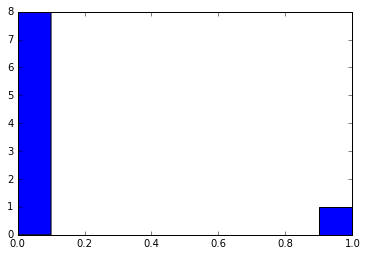

(array([ 2.,  3.,  2.,  2.,  0.,  1.,  0.,  1.,  0.,  1.]),
 array([  1. ,   1.9,   2.8,   3.7,   4.6,   5.5,   6.4,   7.3,   8.2,
          9.1,  10. ]),
 <a list of 10 Patch objects>)

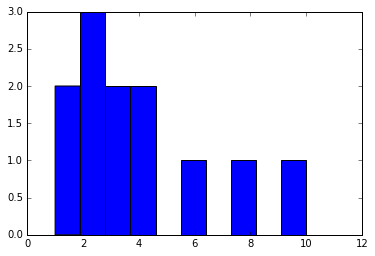

In [42]:
# We now look at the bloc sizes to see if something interesting happens here
# We take the last signature of each candidate, because it is the longest. Other signatures could work too
last_sign_clinton = sign_clinton[3]
last_sign_trump = sign_trump[3]

print("Clinton signature topics: " + ",".join([topics_labels[t] for t in last_sign_clinton["signature"]]))
print("Trump signature topics: " + ",".join([topics_labels[t] for t in last_sign_trump["signature"]]))

clinton_blocks_duration = [(clinton_dates[b[1]].timestamp()-clinton_dates[b[0]].timestamp())/(3600*24) for b in last_sign_clinton["blocs"]]
trump_blocks_duration = [(trump_dates[b[1]].timestamp()-trump_dates[b[0]].timestamp())/(3600*24) for b in last_sign_trump["blocs"]]

plt.hist(clinton_blocks_duration)
plt.show()
plt.hist(trump_blocks_duration)

Clinton signature topics (12 times): Economic policy,Future of African Americans,Criticism of Democrats,Education policy
Trump signature topics (12 times): Economic policy,Future of African Americans,Middle East policy,Criticism of Democrats


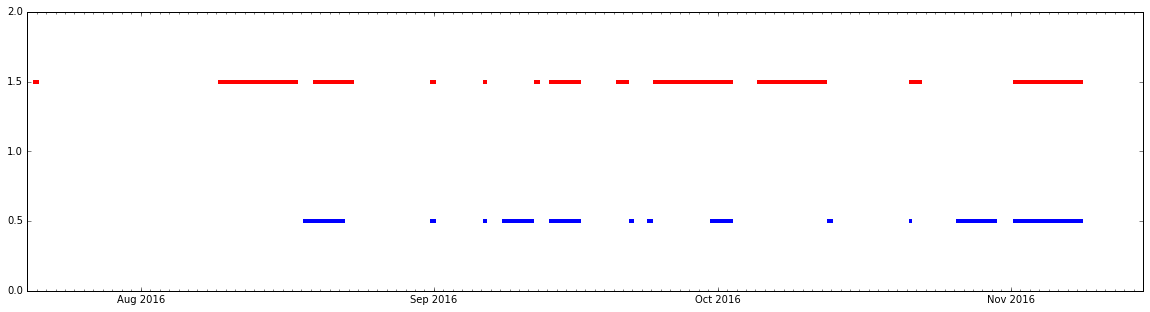

In [103]:
# We are gonna work on these blocs cause they are our main contributions
# First let's look at clinton's blocs
[(clinton_dates[b[1]].timestamp()-clinton_dates[b[0]].timestamp())/(3600*24) for b in last_sign_clinton["blocs"]]
clinton_dates = get_speeches_dates("Clinton")

days = mdates.DayLocator()   # every day
months = mdates.MonthLocator()  # every month

# Init the plot and its properties
fig, ax = plt.subplots()

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.xaxis.set_minor_locator(days)

datemin = datetime.date(min(clinton_dates).year, 7, 20)
datemax = datetime.date(max(clinton_dates).year, 11, 15)
ax.set_xlim(datemin, datemax)
ax.set_ylim(0,2)

chosen_sign = sign_trump[3]
print("Clinton signature topics (" + str(len(chosen_sign["blocs"])) + " times): " + ",".join([topics_labels[t] for t in chosen_sign["signature"]]))
for b in chosen_sign["blocs"]:
    ax.hlines(0.5, trump_dates[b[0]]+datetime.timedelta(hours=5), trump_dates[b[1]]-datetime.timedelta(hours=10), color='b', lw=4)
    
chosen_sign = sign_trump[4]
print("Trump signature topics (" + str(len(chosen_sign["blocs"])) + " times): " + ",".join([topics_labels[t] for t in chosen_sign["signature"]]))
for b in chosen_sign["blocs"]:
    ax.hlines(1.5, trump_dates[b[0]]+datetime.timedelta(hours=5), trump_dates[b[1]]-datetime.timedelta(hours=10), color='r', lw=4)
fig.set_figheight(5)
fig.set_figwidth(20)
plt.show()

Trump signature topics (15 times): Illegal immigration,New economic policy,Future of nation + african american
[[1, 5], [8, 11], [20, 21], [35, 36], [43, 46], [47, 48], [49, 49], [50, 54], [55, 55], [56, 56], [60, 60], [61, 61], [63, 63], [65, 65], [66, 67]]
Trump signature topics (15 times): School choice for students,New economic policy,Future of nation + african american
[[3, 5], [7, 11], [20, 21], [24, 25], [27, 27], [30, 30], [31, 31], [33, 33], [35, 35], [39, 39], [40, 40], [41, 42], [43, 43], [53, 54], [63, 64]]


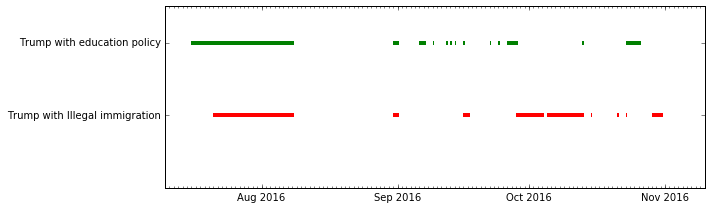

In [232]:
# We study why trump has different signatures at 15 blocs
days = mdates.DayLocator()   # every day
months = mdates.MonthLocator()  # every month

# Init the plot and its properties
fig, ax = plt.subplots()

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.xaxis.set_minor_locator(days)

datemin = datetime.date(min(trump_dates).year+1, 7, 10)
datemax = datetime.date(max(trump_dates).year, 11, 10)
ax.set_xlim(datemin, datemax)
ax.set_ylim(0,0.5)

chosen_sign = sign_trump[2]
print("Trump signature topics (" + str(len(chosen_sign["blocs"])) + " times): " + ",".join([topics_labels[t] for t in chosen_sign["signature"]]))
print(chosen_sign["blocs"])
for b in chosen_sign["blocs"]:
    ax.hlines(0.2, trump_dates[b[0]], trump_dates[b[1]]+datetime.timedelta(hours=10), color='r', lw=4)
    
chosen_sign = sign_trump[3]
print("Trump signature topics (" + str(len(chosen_sign["blocs"])) + " times): " + ",".join([topics_labels[t] for t in chosen_sign["signature"]]))
print(chosen_sign["blocs"])
for b in chosen_sign["blocs"]:
    ax.hlines(0.4, trump_dates[b[0]], trump_dates[b[1]]+datetime.timedelta(hours=10), color='g', lw=4)

ax.set_yticks([0.2,0.4])
ax.set_yticklabels(["Trump with Illegal immigration", "Trump with education policy"])
fig.set_figheight(3)
fig.set_figwidth(10)
fig.tight_layout()
plt.savefig("trump_blocs.pdf")
plt.show()

In [15]:
# To compare ourselves with the method that uses words, let's compute signatures on counts
# We now transform tweets using vectorizers
count_vectorizer = CountVectorizer()
count_vectors = count_vectorizer.fit_transform(clinton_speeches)
inverse_dict_clinton = {v:k for k,v in count_vectorizer.vocabulary_.items()}

In [33]:
clinton_word_dataset = []
trump_dates = get_speeches_dates("Trump")
clinton_dates = get_speeches_dates("Clinton")
jar_path = "./code_these_clement/resources/signatures.jar"

for i, topic in enumerate(count_vectors):
    speech_words = ["%05d" % t for t in find(topic)[1]]
    if speech_words:
        clinton_word_dataset.append({'timestamp':int(clinton_dates[i].timestamp()), 'products':speech_words})
sign_clinton = compute_sky_signature(clinton_word_dataset, jar_path, 60, runner="fr.liglab.datalyse.retail.runners.RunSkySignatureComputation")

In [34]:
last_sign_clinton = sign_clinton[-1]
print("Clinton signature topics: " + ",".join([inverse_dict_clinton[t] for t in last_sign_clinton["signature"]]))

Clinton signature topics: year,many,president,thing,life,way,time,day,great,good,much,right


In [36]:
print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'no